## Applying Bayesian Optimisation for picking parameters for priors to get a certain output

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets  # transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = False
from tqdm.notebook import tqdm

In [158]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [159]:
cnn_weights_path =  "mnist_cnn.pt"
cnn_model = Net().to(dtype=dtype, device=device)
cnn_state_dict = torch.load(cnn_weights_path, map_location=device)
cnn_model.load_state_dict(cnn_state_dict);

In [160]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae_weights_path =  "mnist_vae.pt"
vae_model = VAE().to(dtype=dtype, device=device)
vae_state_dict = torch.load(vae_weights_path, map_location=device)
vae_model.load_state_dict(vae_state_dict);

In [161]:
def score(y):
    """Returns a 'score' for each digit from 0 to 9. It is modeled as a squared exponential
    centered at the digit 'k'.
    """
    return torch.exp(-2 * (y - 9) ** 2)

In [162]:
def score_image(x):
    """The input x is an image and an expected score
    based on the CNN classifier and the scoring
    function is returned.
    """
    with torch.no_grad():
        probs = torch.exp(cnn_model(x))  # b x 10
        scores = score(
            torch.arange(10, device=device, dtype=dtype)
        ).expand(probs.shape)
    return (probs * scores).sum(dim=1)

In [163]:
def decode(train_x):
    with torch.no_grad():
        decoded = vae_model.decode(train_x)
    return decoded.view(train_x.shape[0], 1, 28, 28)

In [164]:
# !pip install botorch

In [165]:
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms import Standardize, Normalize

d = 20
bounds = torch.tensor([[-6.0] * d, [6.0] * d], device=device, dtype=dtype)


def gen_initial_data(n=5):
    # generate training data
    train_x = unnormalize(
        torch.rand(n, d, device=device, dtype=dtype),
        bounds=bounds
    )
    train_obj = score_image(decode(train_x)).unsqueeze(-1)
    best_observed_value = train_obj.max().item()
    return train_x, train_obj, best_observed_value


def get_fitted_model(train_x, train_obj, state_dict=None):
    # initialize and fit model
    model = SingleTaskGP(
        train_X=normalize(train_x, bounds),
        train_Y=train_obj,
        outcome_transform=Standardize(m=1)
    )
    if state_dict is not None:
        model.load_state_dict(state_dict)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    fit_gpytorch_mll(mll)
    return model

In [166]:
from botorch.optim import optimize_acqf


BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 256 if not SMOKE_TEST else 4


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a
    new candidate and a noisy observation"""

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.stack(
            [
                torch.zeros(d, dtype=dtype, device=device),
                torch.ones(d, dtype=dtype, device=device),
            ]
        ),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = score_image(decode(new_x)).unsqueeze(-1)
    return new_x, new_obj

In [167]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

seed = 1
torch.manual_seed(seed)

N_BATCH = 75 if not SMOKE_TEST else 3
best_observed = []

# call helper function to initialize model
train_x, train_obj, best_value = gen_initial_data(n=5)
best_observed.append(best_value)

In [168]:
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")


print(f"\nRunning BO ", end="")

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in tqdm(range(N_BATCH)):

    # fit the model
    model = get_fitted_model(
        train_x=train_x,
        train_obj=train_obj,
        state_dict=state_dict,
    )

    # define the qNEI acquisition function
    qEI = qExpectedImprovement(
        model=model, best_f=train_obj.max()
    )

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qEI)

    # update training points
    train_x = torch.cat((train_x, new_x))
    train_obj = torch.cat((train_obj, new_obj))

    # update progress
    best_value = train_obj.max().item()
    best_observed.append(best_value)

    state_dict = model.state_dict()


Running BO 

  0%|          | 0/75 [00:00<?, ?it/s]

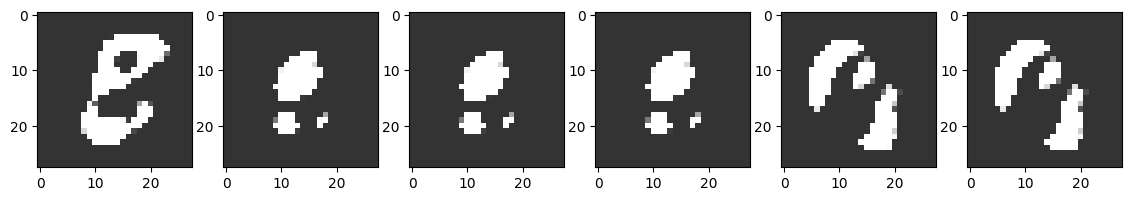

In [169]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline


fig, ax = plt.subplots(1, 6, figsize=(14, 14))
percentages = np.array([0, 10, 25, 50, 75, 100], dtype=np.float32)
inds = (N_BATCH * BATCH_SIZE * percentages / 100 + 4).astype(int)

for i, ax in enumerate(ax.flat):
    b = torch.argmax(score_image(decode(train_x[: inds[i], :])), dim=0)
    img = decode(train_x[b].view(1, -1)).squeeze().cpu()
    ax.imshow(img, alpha=0.8, cmap="gray")